# Example: Multiple individual inference clock-model 

This notebook contains a tutorial on how to perform multi-individual inference for the circadian clock gene-network model using PEPSDI. This corresponds to the example in the paper. 

The clock-data is simulated using the exact Extrande-algorithm. 

Since the model has low molecule-numbers (see paper), approximate stochastic simulators are impractical and inference is performed using the exact Extrande-simulator. 

In [1]:
# To get all the directories correct the directory must be the root directory of the PEPSDI-cloned directory  
cd("/home/sebpe/Dropbox/PhD/Projects/PEPSDI")

# Required packages for formulating a model and do inference 
using Distributions # For placing priors 
using Random # For setting seed 
using LinearAlgebra # For matrix operations 
using Plots
tmp = push!(LOAD_PATH, pwd() * "/Code") # Push PEPSDI into load-path 
using PEPSDI # Load PEPSDI 

## Defining the clock Extrande-model

A Extrande-model (SSA model but with time-varying rate-constants allowed) is defined by a propensity (hazard) vector $\mathbf{h}$ which contains the propensites for each reaction, a stoichiometry matrix $\mathbf{S}$ (describes how the molecules interact in each reaction), the observation model $y_\mathrm{mod} = h(x, t)$ and lastly the error model, $y_{obs} = g(\epsilon)$, $\epsilon \sim \pi_{\epsilon}(\xi)$. To perform inference all these have to be defined. That is, an Extrande-model consists of a:

* Function for the propensity vector (h-vector)
* Function for calculating the maximum value of the propensity vector between $t_{start} \rightarrow t_{end}$
    * This is required by the Extrande-algorithm 
* A stoichiometry matrix
* Function to calculate initial values 
    * Since the initial values can be unknown providing an initial value functions makes it possible to infer initial values 
* Function for the observation y (h)
* Function for the probability of observing y (g)


In [2]:
# The drift vector need to have arguments u, h_vec, p, t 
# u : current state-values 
# h_vec : propensity vector (not allocating new h_vec is computationally efficient)
# p : unknown model-quantites. p.c gives acces to individual parameters c, 
#     while p.kappa gives acces to cell-constants for multi-individual inference.  
# t : current time-value 
function clock_h_vec!(u, h_vec, p, t)
    c = p.c
    const_term = 0.2617993877991494
    h_vec[1] = c[1] * (1 + sin(const_term * t))
    h_vec[2] = c[2] * u[1]
    h_vec[3] = c[3] * u[1]
    h_vec[4] = c[4] * u[2]    
end


# The maximum propensity vector need to have arguments u, h_vec, p, t_start, t_end 
# u : current state-values. Note, the maximum propensity myst be calculated between 
# t_start -> t_end
# h_vec : propensity vector (not allocating new h_vec is computationally efficient)
# p : unknown model-quantites. p.c gives acces to individual parameters c, 
#     while p.kappa gives acces to cell-constants for multi-individual inference.  
# t_start : start-time for calculating maximum h_vec 
# t_end : end-time for calculating maximum h_vec 
function clock_h_vec_max!(u, h_vec, p, t_start, t_end)
    c = p.c
    
    # (1 + sin(const_term * t)) <= 2
    h_vec[1] = c[1] * 2
    h_vec[2] = c[2] * u[1]
    h_vec[3] = c[3] * u[1]
    h_vec[4] = c[4] * u[2]    
end


# The initial-value function needs to have the arguments u0, p. Note 
# for extrande-model the initial values must be a positive integer. 
# u0 : vector with initial values (not allocating new du is efficient)
# p : as above (this allows initial values to be inferred)
function clock_u0!(u0::T1, p) where T1<:Array{<:UInt16, 1}
    u0[1] = 0
    u0[2] = 0
end


# The observation function y = g(X, p) must always have the arguments 
# y_mod, u, p, t
# y_mod : vector with model values at time t 
# u : state-values at time t
# p : as above (this allows y to depend on the parameters)
# t : current time-value 
function clock_h(y_mod, u, p, t)
    y_mod[1] = u[2]
end


# The function for the probability to observe y_mod must always have the arguments 
# y_obs, y_mod, error_param, t, dim_obs. 
# y_obs : vector with observed values at time t (dimension = dim_obs)
# y_obs : vector with model values at time t (dimension = dim_obs)
# error_param : vector with error-parameters xi 
# t : current t-value 
# dim_obs, dimension of the observation vector y. 
function clock_g(y_obs, y_mod, error_param, t, dim_obs)

    # Since y_obs ~ N(y_mod, xi^2) the likelihood can be calculated 
    # via the normal distribution. Perform calculations on log-scale 
    # for stabillity. 

    prob::FLOAT = 0.0
    error_dist = Normal(0.0, error_param[1])
    diff = y_obs[1] - y_mod[1]
    prob = logpdf(error_dist, diff)
    
    return exp(prob)
end


# Setting up stoichiometry matrix 
S_left = convert(Array{Int16, 2}, [0 0; 1 0; 1 0; 0 1])    
S_right = convert(Array{Int16, 2}, [1 0; 1 1; 0 0; 0 0])
S_matrix = S_left - S_right

# Set up the Extrande-model 
my_model = ExtrandModel(clock_h_vec!, clock_h_vec_max!, clock_u0!, clock_h, clock_g, 2, 1, 4, S_left - S_right)

ExtrandModel{typeof(clock_h_vec!),typeof(clock_h_vec_max!),typeof(clock_u0!),typeof(clock_h),typeof(clock_g),Int64,Array{Int16,2}}(clock_h_vec!, clock_h_vec_max!, clock_u0!, clock_h, clock_g, 2, 1, 4, Int16[-1 0; 0 -1; 1 0; 0 1])

## Defining inference options 

When we have a model we can perform the inference. However, before performing the inference we must specify inference options. These are 

* Distribution described by the population parameters $\eta$; $\mathbf{c}_i \sim \pi(\mathbf{c_i} | \eta)$
    * Since we assume that $\mathbf{c} \sim \mathcal{LN}\big(\mu, D(\tau) \Phi D(\tau) \big)$ our population parameters are $\eta = (\mu, \tau, \Phi)$ (they describe the distribution of the cell-individual parameters $\mathbf{c}$). Note $\mathbf{I}$ is the identity matrix.  
* Priors for the population parameters $\eta$, cell-constant parameter $\kappa$ and measurement error-parameters $\xi$.
    * Almost any distribution in the Julia distributions pacakge can be used for placing priors. 
    * Since the model does not have any cell-constant parameters $\kappa$ we do not have to use a priors here. 
* If the population, individual, and cell-constants parameters are inferred on log-scale, and if the parameters are constrained to be positive 
    * Performing inference on the log-scale means to infer $log(c)$ instead of $\mathbf{c}$. This can help explore the posterior more efficiently  (which is why we do it below) inference perspective. 
* Which particle filter to use for pseudo-marginal inference 
    * For the extrande-algorithm only a bootstrap filter can be used 
* If using PEPSDI-runnning option 2, how much $\kappa, \xi$ should vary between cells; $(\kappa_i, \xi_i) \sim \mathcal{N}\big( (\kappa_{pop}, \xi_{pop} ),  \epsilon \mathbf{I} \big), ε \ll 1 $ 
* Which adaptive mcmc-proposals scheme to propose $\kappa_i$, $\xi_i$ and $\mathbf{c}_i$ with.    
    * As noted in the paper, we found the RAM-sampler to be efficient. Thus, we use it below.  
* Location of data-file with observed data and where to save the results 

Since PEPSDI running option 2 (where $\kappa, \xi$ are allowed to vary weakly between cells) is fast we use it below. 

For the population parameters we have that they follow a full log-normal distribution; $\mathbf{c} \sim \mathcal{LN}\big(\mu, D(\tau) \Phi D(\tau) \big)$, where $D(\tau)$ is a diagonal matrix with the standard-devation (scale) vector $\tau$ on the diagonal and $\Phi$ is a correlation matrix. This parameterisation of the covariance matrix is termed the separation approach in the paper (separates scale and correlation), and using HMC we can infer efficiently propose parameters for this parameterisation. For the correlation matrix PEPSDI currently supports a LKJ-prior (more details in: https://mc-stan.org/docs/2_18/stan-users-guide/multivariate-hierarchical-priors-section.html) 



In [3]:
# Prior for population parameters η = (μ, τ, Φ).  
prior_mean = [Normal(0.0, 2.0), # μ
              Normal(2.0, 5.0), 
              Normal(0.0, 5.0), 
              Normal(0.0, 5.0)]
prior_scale = [truncated(Cauchy(0.0, 2.5), 0.0, Inf), # τ
               truncated(Cauchy(0.0, 2.5), 0.0, Inf), 
               truncated(Cauchy(0.0, 2.5), 0.0, Inf), 
               truncated(Cauchy(0.0, 2.5), 0.0, Inf)]
prior_corr = LKJ(4, 3.0) # Φ
    
# Priors for ξ (strict to help with inference )
prior_sigma = [Normal(2.0, 0.5)]

# We do not have any cell-constant parameters ĸ and thus do not place any priors on them 

# Filter information (bootstrap filter for Extrand-algorithm)
filter_opt = init_filter(BootstrapExtrand())
    
# Inference options for η, ĸ and ξ
pop_param_info = init_pop_param_info(prior_mean, 
                                     prior_scale, 
                                     prior_sigma, 
                                     prior_pop_corr=prior_corr, # Φ not always used hence priors must be provided by keyword
                                     pos_pop_sigma = true) # ξ inferred to be positive (and default not on log-scale)

ind_param_info = init_ind_param_info("mean",         # Starting value for pilot run is mean of prior
                                     4,               # Number of individual parameters  
                                     log_scale=true,  # Individual parameters inferred on log-scale 
                                     pos_param=false) # Individual parameters not constrained to be positive 

# Define the distributions for ξ_pop and η
pop_sampler_opt = init_pop_sampler_opt(PopNormalLKJ(), n_warm_up=50) # η
kappa_sigma_sampler_opt = init_kappa_sigma_sampler_opt(KappaSigmaNormal(), variances = [0.01]) # ξ_pop with ε = 0.01 

# Choose adaptive mcmc-scheme when proposing parameters ξ_i and c_i
cov_mat_ci = diagm([0.1, 0.1, 0.1, 0.1])
cov_mat_kappa_sigma = diagm([0.1])
# As seen in the code multiple options can be provided for the RAM-sampler 
mcmc_sampler_ci = init_mcmc(RamSampler(), ind_param_info, cov_mat=cov_mat_ci, step_before_update=250)
mcmc_sampler_kappa_sigma = init_mcmc(RamSampler(), pop_param_info, cov_mat=cov_mat_kappa_sigma, step_before_update=250)

# Set up struct that stores all file-locations 
path_data = pwd() * "/Intermediate/Simulated_data/SSA/Multiple_ind/Clock/Clock.csv"
# Multiple_ind = true -> stored in intermediate under Multiple_individual folder
file_loc = init_file_loc(path_data, "Example/Clock_model", multiple_ind=true)
    

As cauchy distribution is used will change to median for init-param


FileLocations{Array{String,1},Array{Float64,1},Array{Int64,1}}("/home/sebpe/Dropbox/PhD/Projects/PEPSDI/Intermediate/Simulated_data/SSA/Multiple_ind/Clock/Clock.csv", "Example/Clock_model", "/home/sebpe/Dropbox/PhD/Projects/PEPSDI/Intermediate/Multiple_individuals/Example/Clock_model", [""], Float64[], [1])

## Perform pilot run 

To perform efficient pseduo-marginal inference we want to take as many samples as possible, without risking that the chain gets stuck. As noted in the paper this can be achieved if we tune the number of particles. 

A often using tuning approach is to first run a pilot-run to end up in a central posterior location. From this central location the particles can then be tuned according to tuning criteria (see paper supplementary 5.2). 

Many particles should be used in the pilot-run to prevent the mcmc-chain from getting stuck. 

PEPSDI will write the number of particles calculated by the tuning scheme, the tuned adaptive mcmc options, 
and the end-location of the pilot run to disk. Furthermore, to avoid having to re-run a pilot run PEPSDI writes the pilot-run options to disk 

The results from the pilot run is stored in *Intermediate/Multiple_individual/Name_in_file_loc*. For more detail see the tutorial notebook. To avoid having to run quite a costly pilot-run (albeit our Extrande-implementation is fast, this is still quite demaning computations), we have the pilot-results pre-loaded, so that the tuning can be started directly. 

In [6]:
# Set up options for pilot-run 
tune_part_data = init_pilot_run_info(pop_param_info, # Population parameter information 
                                     n_particles_pilot=2000, # Number of particles per individual in pilot-run 
                                     n_samples_pilot=5000,  # Number of samples pilot-run  
                                     rho_list=[0.0],      # Correlation level pilot-run 
                                     n_times_run_filter=50, # Number of times to run filter when tuning 
                                     init_mean=log.([2.0, 35.0, 1.0, 2.0]), 
                                     init_sigma=[0.2]) # Initial values for μ pilot run 

# Tune particles for PEPSDI running option 2 
tune_particles_opt2(tune_part_data, pop_param_info, ind_param_info, 
        file_loc, my_model, filter_opt, mcmc_sampler_ci, mcmc_sampler_kappa_sigma, pop_sampler_opt, kappa_sigma_sampler_opt)
    

As cauchy distribution is used will change to median for init-param
Starting tuning of particles using alternative sampler
Pilot run already existsTuning particles for rho = 0.000
[0.0, 2.0, 0.0, 0.0]
[0.9714231791731177 3.6525952701035687 1.0900680553801156 0.6538387666146601]
[210, 510, 410, 360, 160, 160, 260, 360, 510, 210, 560, 160, 310, 160, 360, 260, 410, 1510, 460, 260, 210, 160, 260, 210, 310, 310, 510, 110, 460, 410, 360, 810, 460, 90, 1060, 310, 310, 110, 160, 510]
Done


## Perform main run 

After the pilot-run the main inference run can be performed. Since the pilot-run, hopefully, arrived at a mode a good starting location is the end-location of the pilot run. 

For the inference inference the end-point of the pilot-run, the adaptive mcmc-sampler options, and the number of particles can be read from disk (since PEPSDI saved these at the end of the pilot run). To do this, notice that each unique pilot-run is equipped with an experimental id (exp_id/exp_tag), this can be used to load the particles from a particular run (see below). Here, we provide exp_tag = 1 to load results from the above pilot run when doing the inference.

In [15]:
# Use 5,000 samples to avoid to long run-time. Since the extrande algorithm simulates each reaction 
# it is recomended to perform the actual inference on a cluster with many cores. 

exp_id = 1
n_samples = 5000
tmp = run_PEPSDI_opt2(n_samples, pop_param_info, ind_param_info, file_loc, my_model, 
    filter_opt, mcmc_sampler_ci, mcmc_sampler_kappa_sigma, pop_sampler_opt, kappa_sigma_sampler_opt, pilot_id=exp_id)
println("Done")

Done


## Plot the inference results

The red-line corresponds to the true-value. As noticed, PEPSDI sucessfully recovers the true mean values $\mu = (\mu_1, \mu_2, \mu_3, \mu_4)$. For the standard-deviations $\tau = (\tau_1, \tau_2, \tau_3, \tau_4)$ we notice larger problems, compared to the manuscript, with $\tau_2, \tau_3, \tau_4$. This is mainly because we took 5000-samples from the posterior, while in the manuscrupt we take $50\,000$, highligthing the importance of running PEPSDI for sufficently many iterations.  

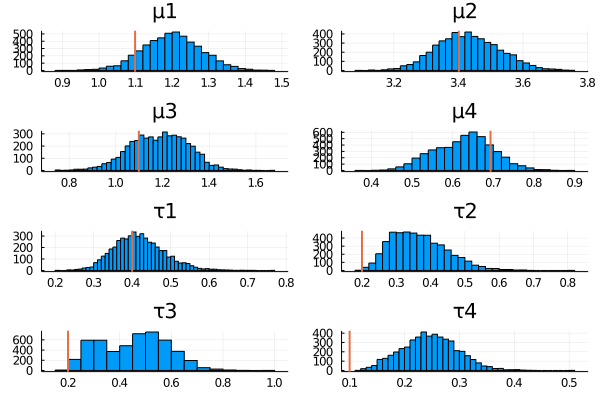

In [25]:
mcmc_chains = tmp[1]

p1 = histogram(mcmc_chains.mean[1, :], title = "µ1", label=false)
vline!(log.([3.0]), lw = 2, label=false)
p2 = histogram(mcmc_chains.mean[2, :], title = "µ2", label=false)
vline!(log.([30.0]), lw = 2, label=false)
p3 = histogram(mcmc_chains.mean[3, :], title = "µ3", label=false)
vline!(log.([3.0]), lw = 2, label=false)
p4 = histogram(mcmc_chains.mean[4, :], title = "µ4", label=false)
vline!(log.([2.0]), lw = 2, label=false)

p5 = histogram(mcmc_chains.scale[1, :], title = "τ1", label=false)
vline!([0.4], lw = 2, label=false)
p6 = histogram(mcmc_chains.scale[2, :], title = "τ2", label=false)
vline!([0.2], lw = 2, label=false)
p7 = histogram(mcmc_chains.scale[3, :], title = "τ3", label=false)
vline!([0.2], lw = 2, label=false)
p8 = histogram(mcmc_chains.scale[4, :], title = "τ4", label=false)
vline!([0.1], lw = 2, label=false)

l = @layout [a b; c d; e f; g h]
plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = l)
